In [5]:
from datasets import load_dataset


dataset = load_dataset("conll2003")


train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

print(train_dataset)
print(validation_dataset)
print(test_dataset)


Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})
Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 3250
})
Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 3453
})


In [6]:
# ============================================
# Experiment Configuration (fixed paths)
# ============================================

import os
from datetime import datetime

# Root directory = current notebook folder 
PROJECT_ROOT = os.getcwd()

# Safer local subdirectories
DATA_DIR     = os.path.join(PROJECT_ROOT, "data")
MODELS_DIR   = os.path.join(PROJECT_ROOT, "models")
RESULTS_DIR  = os.path.join(PROJECT_ROOT, "results")

for path in [DATA_DIR, MODELS_DIR, RESULTS_DIR]:
    os.makedirs(path, exist_ok=True)

experiment_config = {
    "model_name": "bert-base-cased",
    "num_epochs": 3,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "max_length": 128,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "fp16": True,
    "save_dir": os.path.join(MODELS_DIR, f"finetuned_{datetime.now().strftime('%Y%m%d_%H%M%S')}"),
    "results_file": os.path.join(RESULTS_DIR, f"results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"),
}

print(" Experiment configuration ready.")
for k, v in experiment_config.items():
    print(f"{k:20s}: {v}")



 Experiment configuration ready.
model_name          : bert-base-cased
num_epochs          : 3
batch_size          : 16
learning_rate       : 2e-05
max_length          : 128
weight_decay        : 0.01
warmup_ratio        : 0.1
fp16                : True
save_dir            : C:\Users\mbdn1\models\finetuned_20251115_115320
results_file        : C:\Users\mbdn1\results\results_20251115_115320.json


In [7]:
# ============================================
#  Load CoNLL-2003 Dataset & Tokenizer
# ============================================

from datasets import load_dataset
from transformers import AutoTokenizer

# Load dataset 
dataset = load_dataset("conll2003", trust_remote_code=True)

# Initialize tokenizer for BERT-base-cased
tokenizer = AutoTokenizer.from_pretrained(experiment_config["model_name"])

# Display dataset splits
print(dataset)

# Peek at one example
sample = dataset["train"][0]
print("\nSample from train split:")
print(f"Tokens     : {sample['tokens']}")
print(f"NER tags   : {sample['ner_tags']}")

# Show what tokenization looks like
tokenized = tokenizer(sample["tokens"], is_split_into_words=True)
print("\nTokenized input IDs:", tokenized["input_ids"][:20])
print("Decoded tokens     :", tokenizer.convert_ids_to_tokens(tokenized["input_ids"])[:20])


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

Sample from train split:
Tokens     : ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
NER tags   : [3, 0, 7, 0, 0, 0, 7, 0, 0]

Tokenized input IDs: [101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102]
Decoded tokens     : ['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']


In [8]:
# ============================================
#  Tokenization + Label Alignment
# ============================================

from tqdm.notebook import tqdm

# Extract label info from the dataset
ner_feature = dataset["train"].features["ner_tags"].feature
id2label = {i: label for i, label in enumerate(ner_feature.names)}
label2id = {label: i for i, label in enumerate(ner_feature.names)}

print("NER label mapping:")
print(id2label)

# ---- Tokenize + align labels ---- #
def tokenize_and_align_labels(examples):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding=False,
        max_length=experiment_config["max_length"],
    )

    aligned_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # ignore special tokens
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])  # label for first subtoken
            else:
                
                label_name = id2label[labels[word_idx]]
                if label_name.startswith("B-"):
                    label_ids.append(label2id["I-" + label_name[2:]])
                else:
                    label_ids.append(labels[word_idx])
            previous_word_idx = word_idx

        aligned_labels.append(label_ids)

    tokenized["labels"] = aligned_labels
    return tokenized


# Apply the function to all splits
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    desc="Tokenizing and aligning labels",
)


print("\nTokenization and label alignment complete!")
print(tokenized_datasets)
print("\nExample tokenized entry:")
example = tokenized_datasets["train"][0]
print({k: v[:10] for k, v in example.items() if isinstance(v, list)})


NER label mapping:
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


Tokenizing and aligning labels:   0%|          | 0/14041 [00:00<?, ? examples/s]

Tokenizing and aligning labels:   0%|          | 0/3250 [00:00<?, ? examples/s]

Tokenizing and aligning labels:   0%|          | 0/3453 [00:00<?, ? examples/s]


Tokenization and label alignment complete!
DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

Example tokenized entry:
{'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0], 'input_ids': [101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

In [9]:
# ============================================
# Reusable Fine-Tuning Function (Final Version)
# ============================================

from transformers import (
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
import numpy as np
from seqeval.metrics import precision_score, recall_score, f1_score
import json
import os


# --- metric function ---
def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=-1)
    true_preds, true_labels = [], []

    for pred_seq, label_seq in zip(preds, labels):
        cur_preds, cur_labels = [], []
        for p_id, l_id in zip(pred_seq, label_seq):
            if l_id == -100:
                continue
            cur_preds.append(id2label[p_id])
            cur_labels.append(id2label[l_id])
        true_preds.append(cur_preds)
        true_labels.append(cur_labels)

    return {
        "precision": precision_score(true_labels, true_preds),
        "recall": recall_score(true_labels, true_preds),
        "f1": f1_score(true_labels, true_preds),
    }


# --- reusable training function ---
def run_finetuning(config, tokenized_datasets):
    """
    Fine-tune BERT on CoNLL-2003 using parameters in `config`.
    Saves model + metrics automatically.
    """
    print(f"\nStarting fine-tuning for {config['model_name']}")
    os.makedirs(config["save_dir"], exist_ok=True)

    # Load model
    model = AutoModelForTokenClassification.from_pretrained(
        config["model_name"],
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id,
    )

    # Collator for dynamic padding
    data_collator = DataCollatorForTokenClassification(tokenizer)

    # Training arguments 
    try:
        training_args = TrainingArguments(
            output_dir=config["save_dir"],
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=config["learning_rate"],
            per_device_train_batch_size=config["batch_size"],
            per_device_eval_batch_size=config["batch_size"],
            num_train_epochs=config["num_epochs"],
            weight_decay=config["weight_decay"],
            warmup_ratio=config["warmup_ratio"],
            logging_steps=50,
            report_to="none",
            fp16=config["fp16"],
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
        )
    except TypeError:
        # fallback for older Transformers versions
        training_args = TrainingArguments(
            output_dir=config["save_dir"],
            do_eval=True,
            learning_rate=config["learning_rate"],
            per_device_train_batch_size=config["batch_size"],
            per_device_eval_batch_size=config["batch_size"],
            num_train_epochs=config["num_epochs"],
            weight_decay=config["weight_decay"],
            warmup_ratio=config["warmup_ratio"],
            logging_steps=50,
            report_to="none",
            fp16=config["fp16"],
        )

    # ---- Trainer ----
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # ---- Train and evaluate ----
    trainer.train()
    metrics = trainer.evaluate(tokenized_datasets["test"])
    print("\nTest metrics:", metrics)

    # ---- Save model + results ----
    trainer.save_model(config["save_dir"])
    with open(config["results_file"], "w") as f:
        json.dump(metrics, f, indent=2)
    print(f"\n💾 Results saved to {config['results_file']}")
    print(f"💾 Model saved to   {config['save_dir']}")

    return trainer, metrics


In [10]:
# ============================================
# Start Fine-Tuning (Run 1)
# ============================================

# Configuration for Run 1
experiment_config.update({
    "learning_rate": 2e-5,
    "num_epochs": 3,
    "batch_size": 16,
    "save_dir": os.path.join(MODELS_DIR, "bert_lr2e5_ep3_bs16"),
    "results_file": os.path.join(RESULTS_DIR, "bert_lr2e5_ep3_bs16.json"),
})

# Start training
trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)



Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,2.120800
100,1.023100
150,0.520500
200,0.313400
250,0.232600
300,0.177500
350,0.118900
400,0.128100
450,0.126800
500,0.122300



Test metrics: {'eval_loss': 0.17203058302402496, 'eval_precision': 0.8833190761334474, 'eval_recall': 0.914776754075124, 'eval_f1': 0.8987727391417878, 'eval_runtime': 5.2981, 'eval_samples_per_second': 651.747, 'eval_steps_per_second': 40.77, 'epoch': 3.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr2e5_ep3_bs16.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr2e5_ep3_bs16


In [11]:
# ============================================
# Fine-Tuning Experiment 
# ============================================

experiment_config.update({
    "learning_rate": 3e-5,   
    "num_epochs": 3,         
    "batch_size": 16,        
    "save_dir": os.path.join(MODELS_DIR, "bert_lr3e5_ep3_bs16"),   
    "results_file": os.path.join(RESULTS_DIR, "bert_lr3e5_ep3_bs16.json"), 
})

trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)



Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.977700
100,0.811200
150,0.390300
200,0.227100
250,0.190000
300,0.155800
350,0.113200
400,0.113600
450,0.119200
500,0.107600



Test metrics: {'eval_loss': 0.18000313639640808, 'eval_precision': 0.8870386266094421, 'eval_recall': 0.9154854712969526, 'eval_f1': 0.9010375795622985, 'eval_runtime': 6.6775, 'eval_samples_per_second': 517.108, 'eval_steps_per_second': 32.347, 'epoch': 3.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr3e5_ep3_bs16.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr3e5_ep3_bs16


In [12]:
# ============================================
# Fine-Tuning 
# ============================================

# Configuration for Run
experiment_config.update({
    "learning_rate": 2e-5,
    "num_epochs": 5,
    "batch_size": 16,
    "save_dir": os.path.join(MODELS_DIR, "bert_lr2e5_ep5_bs16"),
    "results_file": os.path.join(RESULTS_DIR, "bert_lr2e5_ep5_bs16.json"),
})

# Start training
trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)



Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,2.166800
100,1.308400
150,0.700700
200,0.441300
250,0.302800
300,0.217400
350,0.149800
400,0.145900
450,0.142100
500,0.131200



Test metrics: {'eval_loss': 0.19718238711357117, 'eval_precision': 0.8889270976616231, 'eval_recall': 0.9160170092133239, 'eval_f1': 0.9022687609075044, 'eval_runtime': 6.568, 'eval_samples_per_second': 525.727, 'eval_steps_per_second': 32.887, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr2e5_ep5_bs16.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr2e5_ep5_bs16


In [13]:
# ============================================
#Fine-Tuning 
# ============================================

# Configuration for Run 
experiment_config.update({
    "learning_rate": 3e-5,
    "num_epochs": 5,
    "batch_size": 16,
    "save_dir": os.path.join(MODELS_DIR, "bert_lr3e5_ep5_bs16"),
    "results_file": os.path.join(RESULTS_DIR, "bert_lr3e5_ep5_bs16.json"),
})

# Start training
trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)



Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,2.089300
100,1.090400
150,0.565900
200,0.331900
250,0.241300
300,0.181100
350,0.125900
400,0.126600
450,0.135900
500,0.127000



Test metrics: {'eval_loss': 0.2097415030002594, 'eval_precision': 0.8881094952951241, 'eval_recall': 0.9197377746279235, 'eval_f1': 0.9036469666637653, 'eval_runtime': 5.639, 'eval_samples_per_second': 612.347, 'eval_steps_per_second': 38.305, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr3e5_ep5_bs16.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr3e5_ep5_bs16


In [14]:
# ============================================
# Start Fine-Tuning (Run 1)
# ============================================

# Configuration for Run
experiment_config.update({
    "learning_rate": 5e-5,
    "num_epochs": 3,
    "batch_size": 16,
    "save_dir": os.path.join(MODELS_DIR, "bert_lr5e5_ep3_bs16"),
    "results_file": os.path.join(RESULTS_DIR, "bert_lr5e5_ep3_bs16.json"),
})

# Start training
trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)



Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.803200
100,0.655500
150,0.281700
200,0.194500
250,0.187100
300,0.159800
350,0.103100
400,0.112800
450,0.121600
500,0.109000



Test metrics: {'eval_loss': 0.1744958758354187, 'eval_precision': 0.8916307161345988, 'eval_recall': 0.9154854712969526, 'eval_f1': 0.903400646909695, 'eval_runtime': 5.614, 'eval_samples_per_second': 615.074, 'eval_steps_per_second': 38.476, 'epoch': 3.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr5e5_ep3_bs16.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr5e5_ep3_bs16


In [15]:
# ============================================
#  Fine-Tuning 
# ============================================

# Configuration for Run 
experiment_config.update({
    "learning_rate": 5e-5,
    "num_epochs": 5,
    "batch_size": 16,
    "save_dir": os.path.join(MODELS_DIR, "bert_lr5e5_ep5_bs16"),
    "results_file": os.path.join(RESULTS_DIR, "bert_lr5e5_ep5_bs16.json"),
})

# Start training
trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)



Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.977000
100,0.810300
150,0.389700
200,0.226900
250,0.190100
300,0.156000
350,0.117700
400,0.123400
450,0.125600
500,0.120400



Test metrics: {'eval_loss': 0.21857108175754547, 'eval_precision': 0.8880699348645869, 'eval_recall': 0.9179659815733522, 'eval_f1': 0.9027705175117617, 'eval_runtime': 6.514, 'eval_samples_per_second': 530.088, 'eval_steps_per_second': 33.159, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr5e5_ep5_bs16.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr5e5_ep5_bs16


In [16]:
# ============================================
# Fine-Tuning 
# ============================================

# Configuration for Run 
experiment_config.update({
    "learning_rate": 5e-5,
    "num_epochs": 5,
    "batch_size": 32,
    "save_dir": os.path.join(MODELS_DIR, "bert_lr5e5_ep5_bs32"),
    "results_file": os.path.join(RESULTS_DIR, "bert_lr5e5_ep5_bs32.json"),
})

# Start training
trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)



Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.691000
100,0.517600
150,0.219500
200,0.125900
250,0.129400
300,0.095800
350,0.082600
400,0.075400
450,0.073100
500,0.054400



Test metrics: {'eval_loss': 0.18529222905635834, 'eval_precision': 0.8949724517906336, 'eval_recall': 0.9209780297661233, 'eval_f1': 0.9077890324834089, 'eval_runtime': 4.0645, 'eval_samples_per_second': 849.556, 'eval_steps_per_second': 26.572, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr5e5_ep5_bs32.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr5e5_ep5_bs32


In [17]:
# ============================================
# Fine-Tuning 
# ============================================

# Configuration for Run 
experiment_config.update({
    "learning_rate": 3e-5,
    "num_epochs": 5,
    "batch_size": 32,
    "save_dir": os.path.join(MODELS_DIR, "bert_lr3e5_ep5_bs32"),
    "results_file": os.path.join(RESULTS_DIR, "bert_lr3e5_ep5_bs32.json"),
})

# 🚀 Start training
trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)



Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.875200
100,0.717400
150,0.298700
200,0.154900
250,0.140900
300,0.099500
350,0.088100
400,0.074400
450,0.079200
500,0.056400



Test metrics: {'eval_loss': 0.17884385585784912, 'eval_precision': 0.8884134862228308, 'eval_recall': 0.9197377746279235, 'eval_f1': 0.903804300513624, 'eval_runtime': 4.0075, 'eval_samples_per_second': 861.63, 'eval_steps_per_second': 26.949, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr3e5_ep5_bs32.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr3e5_ep5_bs32


In [18]:
# ============================================
# Fine-Tuning 
# ============================================

# Configuration for Run 
experiment_config.update({
    "learning_rate": 2e-5,
    "num_epochs": 5,
    "batch_size": 32,
    "save_dir": os.path.join(MODELS_DIR, "bert_lr2e5_ep5_bs32"),
    "results_file": os.path.join(RESULTS_DIR, "bert_lr2e5_ep5_bs32.json"),
})

# Start training
trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)



Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,2.000400
100,0.887400
150,0.406500
200,0.200300
250,0.164600
300,0.115300
350,0.099800
400,0.081200
450,0.086600
500,0.065400



Test metrics: {'eval_loss': 0.17124372720718384, 'eval_precision': 0.8884701045057393, 'eval_recall': 0.9188518781006378, 'eval_f1': 0.9034056266875707, 'eval_runtime': 3.8634, 'eval_samples_per_second': 893.782, 'eval_steps_per_second': 27.955, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr2e5_ep5_bs32.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr2e5_ep5_bs32


In [19]:
# ============================================
# Fine-Tuning 
# ============================================

# Configuration for Run
experiment_config.update({
    "learning_rate": 5e-5,
    "num_epochs": 3,
    "batch_size": 32,
    "save_dir": os.path.join(MODELS_DIR, "bert_lr5e5_ep3_bs32"),
    "results_file": os.path.join(RESULTS_DIR, "bert_lr5e5_ep3_bs32.json"),
})

# Start training
trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)



Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.522400
100,0.384400
150,0.186800
200,0.115300
250,0.114000
300,0.085800
350,0.081700
400,0.064200
450,0.068100
500,0.047500



Test metrics: {'eval_loss': 0.15965937077999115, 'eval_precision': 0.8843980133584518, 'eval_recall': 0.9149539333805812, 'eval_f1': 0.8994165287816772, 'eval_runtime': 4.0791, 'eval_samples_per_second': 846.519, 'eval_steps_per_second': 26.477, 'epoch': 3.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr5e5_ep3_bs32.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr5e5_ep3_bs32


In [20]:
# ============================================
#Start Fine-Tuning 
# ============================================

# Configuration for Run 
experiment_config.update({
    "learning_rate": 3e-5,
    "num_epochs": 3,
    "batch_size": 32,
    "save_dir": os.path.join(MODELS_DIR, "bert_lr3e5_ep3_bs32"),
    "results_file": os.path.join(RESULTS_DIR, "bert_lr3e5_ep3_bs32.json"),
})

# Start training
trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)



Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.690400
100,0.505100
150,0.210800
200,0.123100
250,0.126400
300,0.092300
350,0.079300
400,0.070300
450,0.074900
500,0.053300



Test metrics: {'eval_loss': 0.15105868875980377, 'eval_precision': 0.8841002747252747, 'eval_recall': 0.9122962437987243, 'eval_f1': 0.8979769794209976, 'eval_runtime': 3.9319, 'eval_samples_per_second': 878.197, 'eval_steps_per_second': 27.467, 'epoch': 3.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr3e5_ep3_bs32.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr3e5_ep3_bs32


In [21]:
# ============================================
# Fine-Tuning 
# ============================================

# Configuration for Run
experiment_config.update({
    "learning_rate": 2e-5,
    "num_epochs": 3,
    "batch_size": 32,
    "save_dir": os.path.join(MODELS_DIR, "bert_lr2e5_ep3_bs32"),
    "results_file": os.path.join(RESULTS_DIR, "bert_lr2e5_ep3_bs32.json"),
})

# Start training
trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)



Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.841300
100,0.654900
150,0.273200
200,0.145300
250,0.140300
300,0.102000
350,0.090600
400,0.075300
450,0.082500
500,0.062000



Test metrics: {'eval_loss': 0.15349237620830536, 'eval_precision': 0.876218156949906, 'eval_recall': 0.9080439404677534, 'eval_f1': 0.8918472113460368, 'eval_runtime': 4.0506, 'eval_samples_per_second': 852.459, 'eval_steps_per_second': 26.662, 'epoch': 3.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr2e5_ep3_bs32.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr2e5_ep3_bs32


All experiment results:


,Experiment,Precision,Recall,F1,Loss
0,bert_lr5e5_ep5_bs32,0.894972,0.920978,0.907789,0.185292
1,bert_lr3e-05_ep5_bs32_seed2025,0.889535,0.921687,0.905325,0.176802
2,bert_lr3e-05_ep5_bs16_seed2025,0.890800,0.917789,0.904093,0.202344
3,bert_lr3e5_ep5_bs32,0.888413,0.919738,0.903804,0.178844
4,bert_lr3e5_ep5_bs16,0.888109,0.919738,0.903647,0.209742
5,bert_lr2e5_ep5_bs32,0.888470,0.918852,0.903406,0.171244
6,bert_lr5e5_ep3_bs16,0.891631,0.915485,0.903401,0.174496
7,bert_lr3e-05_ep5_bs16_seed42,0.887710,0.918852,0.903012,0.216410
8,bert_lr5e5_ep5_bs16,0.888070,0.917966,0.902771,0.218571
9,bert_lr2e5_ep5_bs16,0.888927,0.916017,0.902269,0.197182


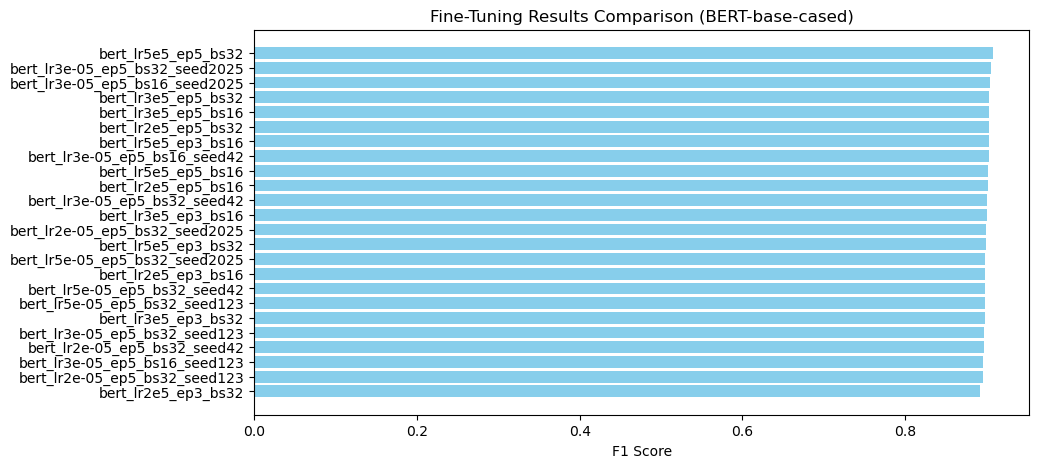

In [22]:
# ============================================
# Collect and Compare All Results
# ============================================

import pandas as pd
import json
import glob
import matplotlib.pyplot as plt

# Collect all JSON files in the results directory
result_files = glob.glob(os.path.join(RESULTS_DIR, "*.json"))

all_results = []
for file in result_files:
    with open(file, "r") as f:
        metrics = json.load(f)
    name = os.path.basename(file).replace(".json", "")
    all_results.append({
        "Experiment": name,
        "Precision": metrics.get("eval_precision", None),
        "Recall": metrics.get("eval_recall", None),
        "F1": metrics.get("eval_f1", None),
        "Loss": metrics.get("eval_loss", None),
    })

# Create DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by="F1", ascending=False).reset_index(drop=True)

print("All experiment results:")
display(results_df)

# Plot comparison
plt.figure(figsize=(10, 5))
plt.barh(results_df["Experiment"], results_df["F1"], color="skyblue")
plt.xlabel("F1 Score")
plt.title("Fine-Tuning Results Comparison (BERT-base-cased)")
plt.gca().invert_yaxis()
plt.show()


#### we will continue with first 4's hyperparameter


In [23]:
#### Seed part

In [24]:
# ================================================
# Focused Fine-Tuning Loop (Top 4 Configs × 3 Seeds)
# ================================================
from transformers import set_seed
import os

# Define top 4 best configurations from previous experiments
top_configs = [
    (5e-5, 5, 32),
    (3e-5, 5, 32),
    (3e-5, 5, 16),
    (2e-5, 5, 32),
]

# Define seeds for reproducibility
seeds = [42, 123, 2025]

print(f" Total runs: {len(top_configs)} × {len(seeds)} = {len(top_configs) * len(seeds)} experiments\n")

for lr, ep, bs in top_configs:
    for seed in seeds:
        set_seed(seed)

        run_name = f"bert_lr{lr:.0e}_ep{ep}_bs{bs}_seed{seed}"

        # Update config
        experiment_config.update({
            "learning_rate": lr,
            "num_epochs": ep,
            "batch_size": bs,
            "save_dir": os.path.join(MODELS_DIR, run_name),
            "results_file": os.path.join(RESULTS_DIR, f"{run_name}.json"),
        })

        print(f"\n Starting run: {run_name}")
        trainer, metrics = run_finetuning(experiment_config, tokenized_datasets)

        # Add metadata
        metrics["seed"] = seed
        metrics["learning_rate"] = lr
        metrics["epochs"] = ep
        metrics["batch_size"] = bs
        metrics["run_name"] = run_name

        # Save again with extended info
        with open(experiment_config["results_file"], "w") as f:
            json.dump(metrics, f, indent=2)

        print(f" Finished {run_name}\n{'-'*80}")


 Total runs: 4 × 3 = 12 experiments


 Starting run: bert_lr5e-05_ep5_bs32_seed42

Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.703900
100,0.521400
150,0.219500
200,0.134700
250,0.130000
300,0.097900
350,0.084400
400,0.073300
450,0.075000
500,0.053900



Test metrics: {'eval_loss': 0.19006654620170593, 'eval_precision': 0.8834303320780554, 'eval_recall': 0.9144223954642098, 'eval_f1': 0.8986592373324046, 'eval_runtime': 3.3253, 'eval_samples_per_second': 1038.391, 'eval_steps_per_second': 32.478, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr5e-05_ep5_bs32_seed42.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr5e-05_ep5_bs32_seed42
 Finished bert_lr5e-05_ep5_bs32_seed42
--------------------------------------------------------------------------------

 Starting run: bert_lr5e-05_ep5_bs32_seed123

Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.590700
100,0.480400
150,0.218600
200,0.127700
250,0.123800
300,0.091900
350,0.084400
400,0.071700
450,0.074400
500,0.050000



Test metrics: {'eval_loss': 0.1826798915863037, 'eval_precision': 0.8823529411764706, 'eval_recall': 0.9142452161587526, 'eval_f1': 0.898016011138183, 'eval_runtime': 4.2501, 'eval_samples_per_second': 812.447, 'eval_steps_per_second': 25.411, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr5e-05_ep5_bs32_seed123.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr5e-05_ep5_bs32_seed123
 Finished bert_lr5e-05_ep5_bs32_seed123
--------------------------------------------------------------------------------

 Starting run: bert_lr5e-05_ep5_bs32_seed2025

Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.712700
100,0.507400
150,0.215400
200,0.125800
250,0.127600
300,0.095400
350,0.082500
400,0.075100
450,0.072200
500,0.048500



Test metrics: {'eval_loss': 0.18723200261592865, 'eval_precision': 0.882162346521146, 'eval_recall': 0.9165485471296952, 'eval_f1': 0.8990267639902677, 'eval_runtime': 3.3638, 'eval_samples_per_second': 1026.525, 'eval_steps_per_second': 32.107, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr5e-05_ep5_bs32_seed2025.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr5e-05_ep5_bs32_seed2025
 Finished bert_lr5e-05_ep5_bs32_seed2025
--------------------------------------------------------------------------------

 Starting run: bert_lr3e-05_ep5_bs32_seed42

Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.886500
100,0.721700
150,0.298600
200,0.157200
250,0.145100
300,0.100600
350,0.089300
400,0.077300
450,0.078200
500,0.058300



Test metrics: {'eval_loss': 0.183818981051445, 'eval_precision': 0.8849436667804712, 'eval_recall': 0.9184975194897236, 'eval_f1': 0.9014084507042254, 'eval_runtime': 3.9305, 'eval_samples_per_second': 878.522, 'eval_steps_per_second': 27.478, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr3e-05_ep5_bs32_seed42.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr3e-05_ep5_bs32_seed42
 Finished bert_lr3e-05_ep5_bs32_seed42
--------------------------------------------------------------------------------

 Starting run: bert_lr3e-05_ep5_bs32_seed123

Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.757700
100,0.668600
150,0.286300
200,0.152300
250,0.141500
300,0.107300
350,0.087800
400,0.073000
450,0.079700
500,0.054800



Test metrics: {'eval_loss': 0.18057842552661896, 'eval_precision': 0.8807574206755373, 'eval_recall': 0.914776754075124, 'eval_f1': 0.8974448114027463, 'eval_runtime': 3.7207, 'eval_samples_per_second': 928.049, 'eval_steps_per_second': 29.027, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr3e-05_ep5_bs32_seed123.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr3e-05_ep5_bs32_seed123
 Finished bert_lr3e-05_ep5_bs32_seed123
--------------------------------------------------------------------------------

 Starting run: bert_lr3e-05_ep5_bs32_seed2025

Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.896000
100,0.712800
150,0.281500
200,0.154700
250,0.143700
300,0.105400
350,0.087000
400,0.076300
450,0.079100
500,0.054800



Test metrics: {'eval_loss': 0.1768023520708084, 'eval_precision': 0.8895348837209303, 'eval_recall': 0.9216867469879518, 'eval_f1': 0.9053254437869822, 'eval_runtime': 3.7433, 'eval_samples_per_second': 922.45, 'eval_steps_per_second': 28.852, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr3e-05_ep5_bs32_seed2025.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr3e-05_ep5_bs32_seed2025
 Finished bert_lr3e-05_ep5_bs32_seed2025
--------------------------------------------------------------------------------

 Starting run: bert_lr3e-05_ep5_bs16_seed42

Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,2.075700
100,1.121300
150,0.563300
200,0.331200
250,0.236300
300,0.184700
350,0.132700
400,0.138000
450,0.134300
500,0.126500



Test metrics: {'eval_loss': 0.21641035377979279, 'eval_precision': 0.8877096884628551, 'eval_recall': 0.9188518781006378, 'eval_f1': 0.9030123628765454, 'eval_runtime': 6.26, 'eval_samples_per_second': 551.598, 'eval_steps_per_second': 34.505, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr3e-05_ep5_bs16_seed42.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr3e-05_ep5_bs16_seed42
 Finished bert_lr3e-05_ep5_bs16_seed42
--------------------------------------------------------------------------------

 Starting run: bert_lr3e-05_ep5_bs16_seed123

Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.953100
100,1.034600
150,0.520800
200,0.312600
250,0.242100
300,0.180800
350,0.126400
400,0.129000
450,0.129300
500,0.121100



Test metrics: {'eval_loss': 0.2117662876844406, 'eval_precision': 0.8794338335607094, 'eval_recall': 0.9137136782423813, 'eval_f1': 0.8962460896767466, 'eval_runtime': 6.5152, 'eval_samples_per_second': 529.993, 'eval_steps_per_second': 33.153, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr3e-05_ep5_bs16_seed123.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr3e-05_ep5_bs16_seed123
 Finished bert_lr3e-05_ep5_bs16_seed123
--------------------------------------------------------------------------------

 Starting run: bert_lr3e-05_ep5_bs16_seed2025

Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,2.083800
100,1.134000
150,0.541300
200,0.317700
250,0.236400
300,0.179600
350,0.129400
400,0.132600
450,0.133500
500,0.127700



Test metrics: {'eval_loss': 0.20234379172325134, 'eval_precision': 0.8907996560619088, 'eval_recall': 0.9177888022678952, 'eval_f1': 0.9040928527794746, 'eval_runtime': 5.1392, 'eval_samples_per_second': 671.889, 'eval_steps_per_second': 42.03, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr3e-05_ep5_bs16_seed2025.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr3e-05_ep5_bs16_seed2025
 Finished bert_lr3e-05_ep5_bs16_seed2025
--------------------------------------------------------------------------------

 Starting run: bert_lr2e-05_ep5_bs32_seed42

Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,2.001400
100,0.907200
150,0.400800
200,0.196400
250,0.164800
300,0.119100
350,0.102900
400,0.082700
450,0.089100
500,0.065700



Test metrics: {'eval_loss': 0.1754453331232071, 'eval_precision': 0.8804774083546462, 'eval_recall': 0.9149539333805812, 'eval_f1': 0.8973846554870101, 'eval_runtime': 3.7351, 'eval_samples_per_second': 924.469, 'eval_steps_per_second': 28.915, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr2e-05_ep5_bs32_seed42.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr2e-05_ep5_bs32_seed42
 Finished bert_lr2e-05_ep5_bs32_seed42
--------------------------------------------------------------------------------

 Starting run: bert_lr2e-05_ep5_bs32_seed123

Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.873100
100,0.840400
150,0.368400
200,0.187100
250,0.154800
300,0.118700
350,0.101400
400,0.078900
450,0.088600
500,0.064700



Test metrics: {'eval_loss': 0.17422156035900116, 'eval_precision': 0.8795632889798704, 'eval_recall': 0.9135364989369241, 'eval_f1': 0.8962280549278637, 'eval_runtime': 3.8566, 'eval_samples_per_second': 895.337, 'eval_steps_per_second': 28.004, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr2e-05_ep5_bs32_seed123.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr2e-05_ep5_bs32_seed123
 Finished bert_lr2e-05_ep5_bs32_seed123
--------------------------------------------------------------------------------

 Starting run: bert_lr2e-05_ep5_bs32_seed2025

Starting fine-tuning for bert-base-cased


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mbdn1\AppData\Local\Temp\ipykernel_12156\934232259.py:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,2.009500
100,0.910700
150,0.376600
200,0.193700
250,0.162100
300,0.119500
350,0.101100
400,0.083800
450,0.088700
500,0.064500



Test metrics: {'eval_loss': 0.17149899899959564, 'eval_precision': 0.8843653780362641, 'eval_recall': 0.9160170092133239, 'eval_f1': 0.8999129677980853, 'eval_runtime': 3.2394, 'eval_samples_per_second': 1065.927, 'eval_steps_per_second': 33.339, 'epoch': 5.0}

💾 Results saved to C:\Users\mbdn1\results\bert_lr2e-05_ep5_bs32_seed2025.json
💾 Model saved to   C:\Users\mbdn1\models\bert_lr2e-05_ep5_bs32_seed2025
 Finished bert_lr2e-05_ep5_bs32_seed2025
--------------------------------------------------------------------------------


In [25]:
# ================================================
# 📊 Aggregate and Compare Results
# ================================================
import pandas as pd
import json
import os
from glob import glob

# Load all JSON result files from results directory
result_files = glob(os.path.join(RESULTS_DIR, "bert_*.json"))

results = []
for fpath in result_files:
    with open(fpath, "r") as f:
        data = json.load(f)
        data["file_name"] = os.path.basename(fpath)
        results.append(data)

# Convert to DataFrame
df = pd.DataFrame(results)

# Keep only relevant columns
metrics_cols = ["run_name", "learning_rate", "epochs", "batch_size", "seed",
                "eval_f1", "eval_precision", "eval_recall", "eval_loss"]
df = df[metrics_cols]

# Sort by F1 descending
df = df.sort_values(by="eval_f1", ascending=False).reset_index(drop=True)

print(f"Loaded {len(df)} experiment results.\n")
display(df.head(10))

# Group by hyperparameters to compute mean/variance across seeds
summary = (
    df.groupby(["learning_rate", "epochs", "batch_size"])
      .agg({
          "eval_f1": ["mean", "std"],
          "eval_precision": "mean",
          "eval_recall": "mean",
          "eval_loss": "mean"
      })
      .round(4)
      .reset_index()
)

summary.columns = ["learning_rate", "epochs", "batch_size", 
                   "f1_mean", "f1_std", "precision_mean", "recall_mean", "loss_mean"]

print("\n📈 Summary by configuration (averaged over seeds):")
display(summary.sort_values(by="f1_mean", ascending=False).reset_index(drop=True))

# Save summary to a CSV file for convenience
summary_path = os.path.join(RESULTS_DIR, "summary_across_seeds.csv")
summary.to_csv(summary_path, index=False)
print(f"\ Summary saved to: {summary_path}")


Loaded 24 experiment results.



,run_name,learning_rate,epochs,batch_size,seed,eval_f1,eval_precision,eval_recall,eval_loss
0,NaN,NaN,NaN,NaN,NaN,0.907789,0.894972,0.920978,0.185292
1,bert_lr3e-05_ep5_bs32_seed2025,0.00003,5.0,32.0,2025.0,0.905325,0.889535,0.921687,0.176802
2,bert_lr3e-05_ep5_bs16_seed2025,0.00003,5.0,16.0,2025.0,0.904093,0.890800,0.917789,0.202344
3,NaN,NaN,NaN,NaN,NaN,0.903804,0.888413,0.919738,0.178844
4,NaN,NaN,NaN,NaN,NaN,0.903647,0.888109,0.919738,0.209742
5,NaN,NaN,NaN,NaN,NaN,0.903406,0.888470,0.918852,0.171244
6,NaN,NaN,NaN,NaN,NaN,0.903401,0.891631,0.915485,0.174496
7,bert_lr3e-05_ep5_bs16_seed42,0.00003,5.0,16.0,42.0,0.903012,0.887710,0.918852,0.216410
8,NaN,NaN,NaN,NaN,NaN,0.902771,0.888070,0.917966,0.218571
9,NaN,NaN,NaN,NaN,NaN,0.902269,0.888927,0.916017,0.197182



📈 Summary by configuration (averaged over seeds):


,learning_rate,epochs,batch_size,f1_mean,f1_std,precision_mean,recall_mean,loss_mean
0,0.00003,5.0,32.0,0.9014,0.0039,0.8851,0.9183,0.1804
1,0.00003,5.0,16.0,0.9011,0.0043,0.8860,0.9168,0.2102
2,0.00005,5.0,32.0,0.8986,0.0005,0.8826,0.9151,0.1867
3,0.00002,5.0,32.0,0.8978,0.0019,0.8815,0.9148,0.1737


\ Summary saved to: C:\Users\mbdn1\results\summary_across_seeds.csv


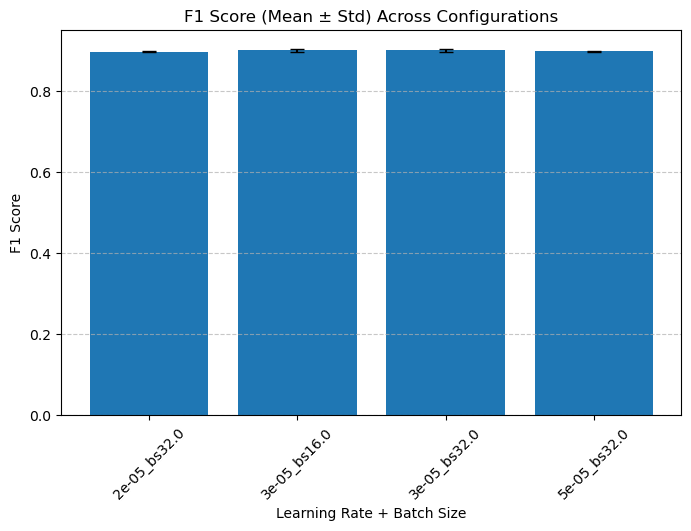

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(summary["learning_rate"].astype(str) + "_bs" + summary["batch_size"].astype(str),
        summary["f1_mean"], yerr=summary["f1_std"], capsize=5)
plt.title("F1 Score (Mean ± Std) Across Configurations")
plt.xlabel("Learning Rate + Batch Size")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
